In [1]:
import tensorflow as tf
import numpy as np

In [2]:
HISTORY_TIMES = [1, 2, 3, 7, 15, 23, 31, 47, 63, 95, 127, 191, 255]

In [3]:
tf.reset_default_graph()

# Training Parameters
learning_rate = 0.001
batch_size = 1

# Network Parameters
num_input = 88 * len(HISTORY_TIMES) + 88       # dimension of one input at moment
num_hidden = 300     # num of lstms in first hidden layer
num_hidden2 = 200    # num of lstms in second hidden layer
num_hidden3 = 150    # num of lstms in second hidden layer
num_output = 88      # output dimension

# tf graph input
X = tf.placeholder("float", [batch_size, None, num_input])

lstm = tf.contrib.rnn.MultiRNNCell([
    tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0),
    tf.contrib.rnn.BasicLSTMCell(num_hidden2, forget_bias=1.0),
    tf.contrib.rnn.BasicLSTMCell(num_hidden3, forget_bias=1.0)
])

lstm_outputs, _ = tf.nn.dynamic_rnn(lstm, X[:, :-1], dtype=tf.float32)

ans = tf.layers.dense(lstm_outputs, num_output)

loss_op = tf.reduce_mean(tf.squared_difference(logits=ans, labels=X[:, 1:, :num_output]))

# define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                   beta1=0.9,
                                   beta2=0.999,
                                   epsilon=1e-08,
                                   use_locking=False,
                                   name='Adam')
# optimizing
train_op = tf.contrib.layers.optimize_loss(
                loss_op, tf.train.get_global_step(), optimizer=optimizer, learning_rate=learning_rate)

init = tf.global_variables_initializer()

In [4]:
# Start training
config = tf.ConfigProto(log_device_placement=True)  # to output is variable on gpu or cpu
config.gpu_options.per_process_gpu_memory_fraction = 0.4  # BlasGEMM launch failed error fix (seems like not enopugh memory on gpu)
sess = tf.Session(config = config)

In [5]:
# Run the initializer
sess.run(init)

In [6]:
songs = np.load("dataset.npy")

In [7]:
def transform(song):    
    ans = song.copy()
    for t in HISTORY_TIMES:
        history = np.roll(song, t, axis=0)
        history[:t] = 0
        ans = np.hstack([ans, history])
    return ans

hsongs = []
for song in songs:
    hsongs.append(transform(song))

In [8]:
training_steps = 20000
display_step = 50

losses = []
for step in range(training_steps + 1):
    # getting data
    batch_x = hsongs[np.random.randint(0, len(songs))][None]
    # Run optimization step
    sess.run(train_op, feed_dict={X: batch_x})
    
    L = sess.run(loss_op, feed_dict={X: batch_x})
    losses.append(L)
    
    if step % display_step == 0:
        print(L)

print("Optimization Finished!")

0.672718
0.0719119
0.0462207
0.0569055
0.0962723
0.0342836
0.0701335
0.0539072
0.037436
0.0872897
0.0779925
0.0618295
0.0482194
0.0479198
0.0617256
0.0387081
0.0488363
0.0552059
0.0499041
0.0641612
0.063319
0.0500925
0.0455477
0.0397186
0.0551298
0.0310404
0.0555488
0.0506892
0.068064
0.0455867
0.0605905


KeyboardInterrupt: 

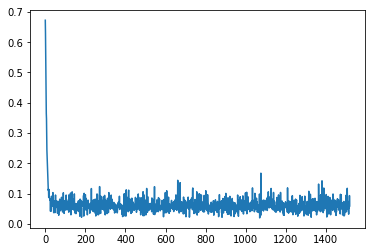

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(losses)

In [10]:
gen = songs[179][:16]

In [11]:
while len(gen) < 512:
    probas = sess.run(tf.sigmoid(ans), feed_dict={X: transform(gen)[None]})

    res = np.random.uniform(0, 1, 88) < probas[0, -1]
    gen = np.vstack([gen, res])

In [12]:
gen

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [13]:
import mido
from mido import MidiFile
import numpy as np
import copy
import math

import matplotlib.pyplot as plt
%matplotlib inline

# для возможности прослушивания midi прямо в ноутбуке
HEARING_PORT = mido.open_output()
# для вывода массивов numpy целиком
np.set_printoptions(threshold=np.nan)

BASE_NOTE = 21
KEYS = 88
FREQ = 4  #ticks for beat

def drawSong(song, scale=(None, None)):
    if scale[0] is None:
        scale = (song.notes.shape[0] / 10, song.notes.shape[1] / 10)
    
    plt.figure(figsize=scale)
    plt.title(song.name)
    plt.imshow(song.notes.T, aspect='auto', origin='lower')
    plt.xlabel("time")
    plt.xticks(np.arange(0, song.notes.shape[0], 4))
    plt.show()
# Класс для создания нового миди файла
class MySong:
    def __init__(self, played_lines=[], finished=False):
        self.name = "Generated song!"
        self.notes = np.zeros((0, 88))

        self.mid = MidiFile(type=0)
        self.track = mido.MidiTrack()
        self.mid.tracks.append(self.track)

        self.time_passed = 0
        self.release = []

        for line in played_lines:
            self.add(line)
           
        if finished:
            self.finish()

    # добавление новых строк в ноты
    def add(self, played):
        self.notes = np.vstack([self.notes, played])

        # "отпуск" нот, сыгранных долю назад
        if played.sum() > 0:
            for i in self.release:
                self.track.append(mido.Message('note_on', note=BASE_NOTE + i, velocity=0, time=self.time_passed))
                self.time_passed = 0
            self.release = []

        # добавление новых нот
        for i, key in enumerate(played):
            if key == 1:
                self.track.append(mido.Message('note_on', note=BASE_NOTE + i, velocity=64, time=self.time_passed))
                self.time_passed = 0
                self.release.append(i)
        self.time_passed += self.mid.ticks_per_beat / FREQ

    # должна быть вызвана в конце создания файла
    def finish(self):
        for i in self.release:
            self.track.append(mido.Message('note_off', note=BASE_NOTE + i, velocity=64, time=self.time_passed))
            self.time_passed = 0
        self.track.append(mido.Message('note_off', note=BASE_NOTE, velocity=0, time=self.time_passed))

    # воспроизведение
    def play(self):
        for msg in self.mid.play():
            HEARING_PORT.send(msg)

    # сохранение
    def save_file(self, name):
        self.mid.save(name + '.mid')

In [14]:
res = MySong(gen)

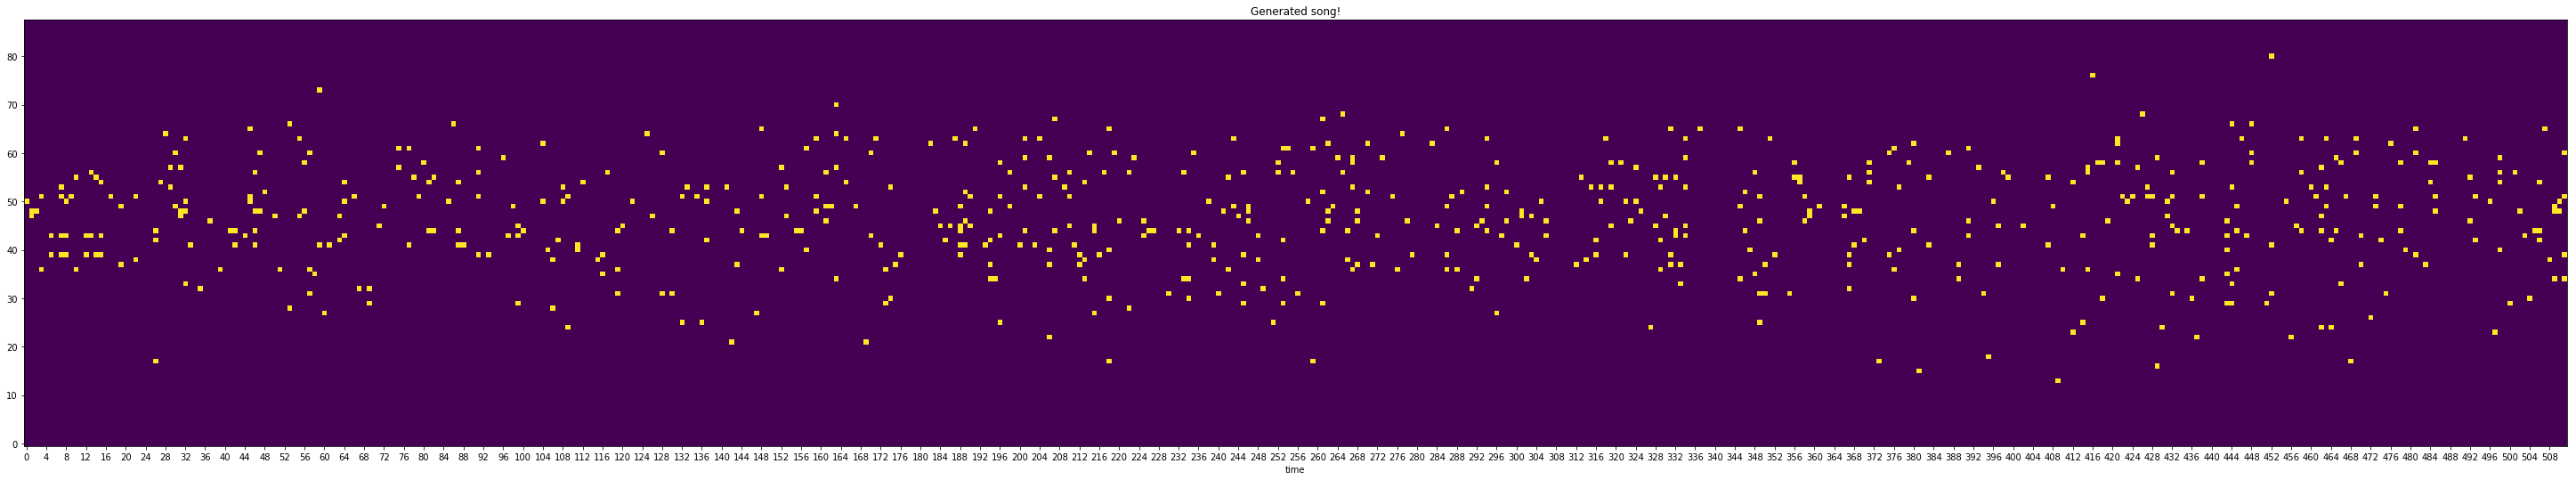

In [15]:
drawSong(res)

In [17]:
res.play()

In [18]:
probas = sess.run(tf.sigmoid(ans), feed_dict={X: transform(gen)[None]})

In [19]:
probas.max()

0.16360091